In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

import aerobulk
from aerobulk import noskin

In [2]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/36077/status,
Dashboard: /user/panalluri/proxy/36077/status,Workers: 4
Total threads: 8,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45655,Workers: 4
Dashboard: /user/panalluri/proxy/36077/status,Total threads: 8
Started: Just now,Total memory: 125.80 GiB
Comm: tcp://127.0.0.1:34849,Total threads: 2
Dashboard: /user/panalluri/proxy/37721/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:32881,


# Select tropical Pacific region

In [4]:
heatfluxHR = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_highRes.zarr", engine="zarr", chunks={}
)
ds_HF = heatfluxHR 
ds_HF

<xarray.Dataset>
Dimensions:                        (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                           (time) object 0181-01-01 12:00:00 ... 0181...
  * xt_ocean                       (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                       (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    __xarray_dataarray_variable__  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

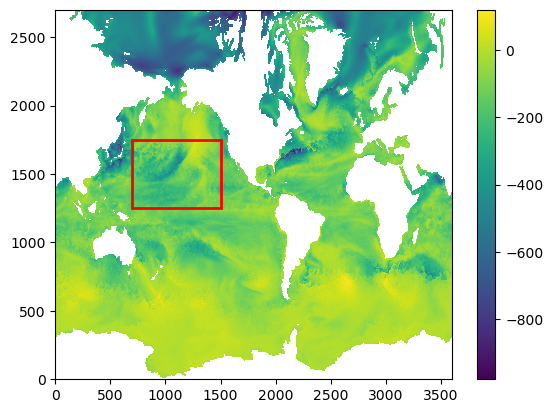

In [23]:
# Extract the data for the specific region
data = ds_HF.__xarray_dataarray_variable__.isel(time=0)

# Plot the data using pcolor
plt.pcolor(data, cmap='viridis')

# Get the bounds of the region (using the indices)
x_min, x_max = 700, 1500
y_min, y_max = 1250, 1750

# Draw a rectangle around the region (the coordinates are based on the index positions)
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)  # Add the rectangle to the current axes

# Show the plot
plt.colorbar()
plt.show()


# Daily time average (base case)
We will definitely need to find averages over small timescales than a day -- this will require finding CM2.6 data that has a high sampling frequency (TODO)!!

In [24]:
ds_tropPac = ds_HF.__xarray_dataarray_variable__.isel(xt_ocean=slice(700,1500), yt_ocean=slice(1250, 1750))
ds_tropPac

<xarray.DataArray '__xarray_dataarray_variable__' (time: 365, yt_ocean: 500,
                                                   xt_ocean: 800)>
dask.array<getitem, shape=(365, 500, 800), dtype=float32, chunksize=(3, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97

In [5]:
from PIL import Image
import os

# Example plotting function for high-resolution (HR) data only
def plot_fun(idt, vmin, vmax): 
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the high-resolution data
    data.isel(time=idt).plot(ax=ax, x='xt_ocean', y='yt_ocean', cmap='bwr', robust=True, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'Surface Heat Flux (W/m²)'})
    ax.set_title(f'High Res - Frame {idt}')

# Animation creation function remains unchanged
def create_animation(fun, idx, filename='HF_dailyAvg_movie.gif', dpi=200, FPS=18, loop=0):
    # Compute global min and max for the variable
    # vmin = data.isel(time=idx).min().compute()
    # vmax = data.isel(time=idx).max().compute()
    vmin = -800
    vmax = 0
    
    frames = []
    for i in idx:
        fun(i, vmin, vmax)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [ ]:
data = ds_tropPac
# Call the animation creation 
create_animation(plot_fun, range(0, 364, 30), 'HF_dayAvg_movie_tropPac.gif', dpi=100, FPS=8)

# 5 day rolling average

In [6]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [7]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

#take a sample of the earth for analysis
ds_highRes = ds_in.isel(time = slice(0,365), xt_ocean=slice(700,1500), yt_ocean=slice(1250, 1750))  
ds_highRes

<xarray.Dataset>
Dimensions:       (time: 365, yt_ocean: 500, xt_ocean: 800)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.2 -130.1
  * yt_ocean      (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.82 44.89 44.97
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [29]:
rolling_avg_5 = ds_highRes.rolling(time=5, center=True, min_periods=1).mean()
rolling_avg_5

<xarray.Dataset>
Dimensions:       (time: 365, xt_ocean: 800, yt_ocean: 500)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.2 -130.1
  * yt_ocean      (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.82 44.89 44.97
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 500, 800), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [30]:
ds_in = rolling_avg_5

ql, qh, taux, tauy, evap =  noskin(
        ds_in.surface_temp,
        ds_in.t_ref,
        ds_in.q_ref,
        ds_in.u_relative,
        ds_in.v_relative,
        slp=ds_in.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_5 = qh + ql
heatflux_5

<xarray.DataArray (time: 365, yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(365, 500, 800), dtype=float32, chunksize=(6, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97

In [31]:
data = heatflux_5
# Call the animation creation 
create_animation(plot_fun, range(0, 364, 30), 'HF_5dayAvg_movie_tropPac.gif', dpi=100, FPS=8)

Animation at FPS=8 will last for 1.625 seconds


# 15 day rolling average

In [32]:
rolling_avg_15 = ds_highRes.rolling(time=15, center=True, min_periods=1).mean()
ds_in = rolling_avg_15

ql, qh, taux, tauy, evap =  noskin(
        ds_in.surface_temp,
        ds_in.t_ref,
        ds_in.q_ref,
        ds_in.u_relative,
        ds_in.v_relative,
        slp=ds_in.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_15 = qh + ql
heatflux_15

<xarray.DataArray (time: 365, yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(365, 500, 800), dtype=float32, chunksize=(16, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97

In [ ]:
data = heatflux_15
# Call the animation creation 
create_animation(plot_fun, range(0, 364, 30), 'HF_15dayAvg_movie_tropPac.gif', dpi=100, FPS=8)

# 30 day rolling average

In [8]:
rolling_avg_30 = ds_highRes.rolling(time=30, center=True, min_periods=1).mean()
ds_in = rolling_avg_30

ql, qh, taux, tauy, evap =  noskin(
        ds_in.surface_temp,
        ds_in.t_ref,
        ds_in.q_ref,
        ds_in.u_relative,
        ds_in.v_relative,
        slp=ds_in.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_30 = qh + ql
heatflux_30

<xarray.DataArray (time: 365, yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(365, 500, 800), dtype=float32, chunksize=(30, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97

In [9]:
data = heatflux_30
# Call the animation creation 
create_animation(plot_fun, range(0, 364, 30), 'HF_30dayAvg_movie_tropPac.gif', dpi=100, FPS=8)

Animation at FPS=8 will last for 1.625 seconds


# Results

In [17]:
from PIL import Image, ImageSequence, ImageDraw, ImageFont

# Load all GIFs
gif1 = Image.open("HF_dayAvg_movie_tropPac.gif")
gif2 = Image.open("HF_5dayAvg_movie_tropPac.gif")
gif3 = Image.open("HF_15dayAvg_movie_tropPac.gif")
gif4 = Image.open("HF_30dayAvg_movie_tropPac.gif")

frames = []

font = ImageFont.load_default()

for f1, f2, f3, f4 in zip(ImageSequence.Iterator(gif1),
                          ImageSequence.Iterator(gif2),
                          ImageSequence.Iterator(gif3),
                          ImageSequence.Iterator(gif4)):

    f1 = f1.convert("RGB")
    f2 = f2.convert("RGB")
    f3 = f3.convert("RGB")
    f4 = f4.convert("RGB")

    w, h = f1.size
    grid = Image.new("RGB", (2*w, 2*h))
    draw = ImageDraw.Draw(grid)

    # Paste the four frames
    grid.paste(f1, (0, 0))
    grid.paste(f2, (w, 0))
    grid.paste(f3, (0, h))
    grid.paste(f4, (w, h))

    # Add labels to each subplot
    draw.text((10, 10), "1-day avg", fill="black", font=font)
    draw.text((w + 10, 10), "5-day avg", fill="black", font=font)
    draw.text((10, h + 10), "15-day avg", fill="black", font=font)
    draw.text((w + 10, h + 10), "30-day avg", fill="black", font=font)

    frames.append(grid)

# Save combined labeled GIF
frames[0].save("HF_timeAvgInput_sensitivity.gif",
               save_all=True, append_images=frames[1:], loop=0, duration=200)

![Heat Flux Animation](HF_timeAvgInput_sensitivity.gif)